In [12]:
#!pip install openpyxl

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import perceval as pcvl
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from merlin import LexGrouping, QuantumLayer, MeasurementStrategy, ComputationSpace
from merlin.builder import CircuitBuilder
import perceval as pcvl

import pandas as pd
import os

In [2]:
DATA_PATH = "./train.xlsx"

# Loading data

In [3]:
# Load training data (day-first dates)
df = pd.read_excel(DATA_PATH)
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values('Date').reset_index(drop=True)

# Keep Date as first column
df = df[['Date'] + [c for c in df.columns if c != 'Date']]
feature_cols = [c for c in df.columns if c != 'Date']

print(f"Rows: {len(df)}")
print(f"Date range: {df['Date'].min().date()} → {df['Date'].max().date()}")
print(f"Number of surface points: {len(feature_cols)}")

df.head()

Rows: 494
Date range: 2050-01-01 → 2051-12-23
Number of surface points: 224


,Date,Tenor : 1; Maturity : 0.0833333333333333,Tenor : 2; Maturity : 0.0833333333333333,Tenor : 3; Maturity : 0.0833333333333333,Tenor : 4; Maturity : 0.0833333333333333,Tenor : 5; Maturity : 0.0833333333333333,Tenor : 6; Maturity : 0.0833333333333333,Tenor : 7; Maturity : 0.0833333333333333,Tenor : 8; Maturity : 0.0833333333333333,Tenor : 9; Maturity : 0.0833333333333333,...,Tenor : 5; Maturity : 30,Tenor : 6; Maturity : 30,Tenor : 7; Maturity : 30,Tenor : 8; Maturity : 30,Tenor : 9; Maturity : 30,Tenor : 10; Maturity : 30,Tenor : 15; Maturity : 30,Tenor : 20; Maturity : 30,Tenor : 25; Maturity : 30,Tenor : 30; Maturity : 30
0,2050-01-01,0.028565,0.038700,0.040127,0.040762,0.040466,0.038953,0.037553,0.036768,0.036646,...,0.331053,0.329056,0.330997,0.324676,0.325758,0.322393,0.345859,0.359162,0.346670,0.337670
1,2050-01-02,0.029334,0.039499,0.040982,0.041638,0.041336,0.039815,0.038397,0.037631,0.037504,...,0.336319,0.334434,0.336568,0.330244,0.331462,0.328144,0.351816,0.365197,0.350993,0.340822
2,2050-01-03,0.028696,0.038816,0.040328,0.041042,0.040804,0.039329,0.037968,0.037216,0.037107,...,0.333634,0.331707,0.333800,0.327487,0.328710,0.325436,0.348915,0.362236,0.348652,0.339027
3,2050-01-05,0.030854,0.041536,0.043035,0.043605,0.043241,0.041556,0.039977,0.039167,0.038968,...,0.336884,0.335106,0.337548,0.331279,0.332811,0.329771,0.353246,0.366100,0.351404,0.340465
4,2050-01-06,0.030406,0.041174,0.042681,0.043266,0.042937,0.041253,0.039685,0.038867,0.038667,...,0.333249,0.331426,0.333830,0.327580,0.329123,0.326146,0.349390,0.362048,0.348331,0.338022


In [16]:
class FinanceDataset(torch.utils.data.Dataset):
    """PyTorch Dataset for swaption volatility data."""
    
    def __init__(self, X, history):
        self.X = torch.FloatTensor(X.values if isinstance(X, pd.DataFrame) else X)
        self.history = history
    
    def __len__(self):
        return len(self.X) - self.history - 1
    
    def __getitem__(self, idx):
        return self.X[idx:idx+self.history], self.X[idx+self.history+1]

In [43]:
# Build a simple PyTorch Dataset using the next-day target
history=2

X = df[feature_cols].copy()
y = df[feature_cols].shift(-1)

# drop last row where target is NaN
mask = ~y.isnull().any(axis=1)
X = X[mask].reset_index(drop=True)
y = y[mask].reset_index(drop=True)

dataset = FinanceDataset(X, history)
print(f"Dataset size: {len(dataset)} samples")
print(f"Feature dim: {X.shape[1]}, Target dim: {y.shape[1]}")

input_dim = X.shape[1]
target_dim = y.shape[1]
dataset[0]

Dataset size: 490 samples
Feature dim: 224, Target dim: 224


(tensor([[0.0286, 0.0387, 0.0401, 0.0408, 0.0405, 0.0390, 0.0376, 0.0368, 0.0366,
          0.0356, 0.0340, 0.0327, 0.0324, 0.0327, 0.0579, 0.0699, 0.0709, 0.0699,
          0.0698, 0.0661, 0.0661, 0.0646, 0.0635, 0.0626, 0.0588, 0.0560, 0.0556,
          0.0567, 0.0950, 0.1047, 0.1013, 0.1004, 0.0987, 0.0968, 0.0923, 0.0902,
          0.0900, 0.0863, 0.0818, 0.0789, 0.0806, 0.0809, 0.1274, 0.1286, 0.1259,
          0.1243, 0.1201, 0.1145, 0.1137, 0.1118, 0.1099, 0.1058, 0.1003, 0.0978,
          0.0963, 0.0988, 0.1551, 0.1497, 0.1455, 0.1386, 0.1372, 0.1299, 0.1284,
          0.1250, 0.1228, 0.1234, 0.1149, 0.1134, 0.1126, 0.1122, 0.1848, 0.1747,
          0.1684, 0.1656, 0.1629, 0.1581, 0.1535, 0.1500, 0.1477, 0.1436, 0.1392,
          0.1323, 0.1324, 0.1347, 0.2011, 0.1945, 0.1910, 0.1854, 0.1814, 0.1744,
          0.1746, 0.1680, 0.1664, 0.1668, 0.1543, 0.1511, 0.1512, 0.1566, 0.2277,
          0.2149, 0.2146, 0.2126, 0.2030, 0.1995, 0.2001, 0.1956, 0.1958, 0.1900,
          0.1836

In [18]:
from torch.utils.data import random_split, DataLoader

trainset, testset = random_split(dataset, [0.8, 0.2])

trainloader = DataLoader(trainset, batch_size=10, shuffle=True)
testloader = DataLoader(testset, batch_size=10, shuffle=False)

In [19]:
# Parsing helpers
def parse_surface_metadata(df):
    tenors, maturities = [], []
    mapping = {}
    for col in df.columns:
        if col == 'Date':
            continue
        parts = col.split(';')
        tenor = float(parts[0].split(':')[1].strip())
        maturity = float(parts[1].split(':')[1].strip())
        tenors.append(tenor)
        maturities.append(maturity)
        mapping[col] = (tenor, maturity)
    return sorted(set(tenors)), sorted(set(maturities)), mapping

def surface_for_date(df, idx, unique_tenors, unique_maturities, mapping):
    row = df.iloc[idx]
    surface = np.full((len(unique_tenors), len(unique_maturities)), np.nan)
    for col, (t, m) in mapping.items():
        t_idx = unique_tenors.index(t)
        m_idx = unique_maturities.index(m)
        surface[t_idx, m_idx] = row[col]
    return surface

unique_tenors, unique_maturities, tm_map = parse_surface_metadata(df)
print(f"Tenors: {len(unique_tenors)} | Maturities: {len(unique_maturities)}")

Tenors: 14 | Maturities: 16


# Testing

In [20]:
def test(model, loader, device="cpu", tolerance=0.10, silent=True):
    model.eval()
    model.to(device)
    
    running_mse = 0.0
    running_mae = 0.0
    correct_threshold = 0
    total_samples = 0
    
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            
            # --- CRITICAL FIX ---
            # Flatten both to (N) to prevent broadcasting errors
            outputs = outputs.view(-1)
            targets = targets.view(-1)
            # --------------------


            # 1. Summed Errors for MSE and MAE
            running_mse += torch.nn.functional.mse_loss(outputs, targets, reduction='sum').item()
            running_mae += torch.nn.functional.l1_loss(outputs, targets, reduction='sum').item()
            
            # 2. Threshold Accuracy
            # Using (outputs - targets) is now safe because shapes match
            relative_error = torch.abs(outputs - targets) / (torch.abs(targets) + 1e-7)
            correct_threshold += (relative_error <= tolerance).sum().item()
            
            total_samples += targets.size(0)

    # Final Metrics
    mse = running_mse / total_samples
    mae = running_mae / total_samples
    accuracy = (correct_threshold / total_samples) * 100

    if not silent:
        print(f"Test Results:")
        print(f"  MSE: {mse:.4f}")
        print(f"  MAE: {mae:.4f}")
        print(f"  Accuracy (within {tolerance*100}%): {accuracy:.2f}%")
    
    return mse, mae, accuracy

In [21]:
def example(model, loader):
    model.eval()
    
    with torch.no_grad():
        inputs, targets = next(iter(loader))
        outputs = model(inputs)
        
        relative_error = torch.abs(outputs - targets) / (torch.abs(targets) + 1e-7)
            
        print(f'Target={targets}, Output={outputs}, Rel_error={relative_error}')

# Training pipeline

In [22]:
def train(model, loss_fn, optim, n_epochs=10, device='cpu'):
    model.train()
    model.to(device)
    l = []

    pbar = tqdm(range(n_epochs))
    
    for i in pbar:
        cur_loss = 0
        cur_samples = 0
        
        for input, target in trainloader:
            input = input.to(device)
            target = target.to(device)
            
            output = model(input)
    
            optim.zero_grad()
            loss = loss_fn(output, target)
            loss.backward()
            optim.step()
            
            cur_loss += loss.sum().cpu().item()
            cur_samples += input.shape[0]
            pbar.set_postfix(loss=cur_loss / cur_samples)
    
        #cur_loss /= len(trainloader)
        #pbar.set_postfix(prev_loss = cur_loss / cur_samples)

# The model

In [23]:
#Classical MLP
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(input_dim*history, 1000),
    nn.ReLU(),
    nn.Linear(1000,target_dim)
)

print(f'Classical MLP size={sum(p.numel() for p in model.parameters() if p.requires_grad)}')

Classical MLP size=673224


Hybrid quantum model size=52560


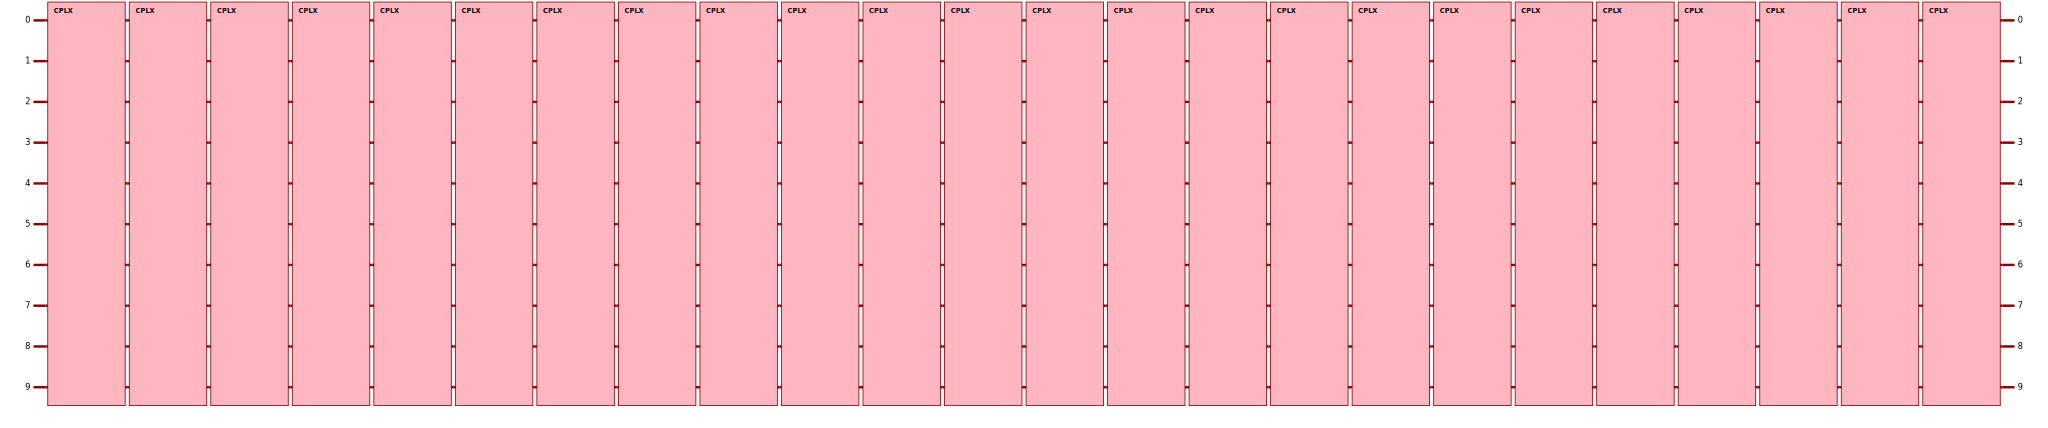

In [16]:
#Hybrid quantum model impl. with MerLin
def create_block(modes, step, max_param, univ_len):
    cir = pcvl.Circuit(modes)

    for i in range(modes):
        if i+step*modes >= max_param:
            break

        cir.add(i, pcvl.PS(pcvl.P(f'input{i+step*modes}')))

    rl = pcvl.GenericInterferometer(
        modes,
        lambda i: pcvl.BS()
        // pcvl.PS(pcvl.P(f"theta_ri{i+univ_len*step}"))
        // pcvl.BS()
        // pcvl.PS(pcvl.P(f"theta_ro{i+univ_len*step}")),
        shape=pcvl.InterferometerShape.RECTANGLE,
    )
    cir.add(0, rl)

    return cir
    

modes = 10
# left generic interferometer
wl = pcvl.GenericInterferometer(
    modes,
    lambda i: pcvl.BS()
    // pcvl.PS(pcvl.P(f"theta_li{i}"))
    // pcvl.BS()
    // pcvl.PS(pcvl.P(f"theta_lo{i}")),
    shape=pcvl.InterferometerShape.RECTANGLE,
)

circuit = pcvl.Circuit(modes)
circuit.add(0,wl)
for i in range(0, input_dim, modes):
    step = i // modes
    circuit.add(0, create_block(modes, step, input_dim, len(wl.params)))

quantum_layer = QuantumLayer(
    input_size=input_dim*history,
    circuit=circuit,
    n_photons=3,
    trainable_parameters=["theta"],
    input_parameters=["input"],
    dtype=dataset.X.dtype,
)

model = nn.Sequential(
    nn.Flatten(),
    quantum_layer,
    LexGrouping(quantum_layer.output_size, target_dim),
    nn.Linear(target_dim, target_dim)
)

print(f'Hybrid quantum model size={sum(p.numel() for p in model.parameters() if p.requires_grad)}')
pcvl.pdisplay(circuit)

# Playground

In [24]:
from torch.optim import Adam

device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 1e-3
loss_fn = nn.MSELoss()
optim = Adam(model.parameters(), lr=lr)

train(model, loss_fn, optim, device=device, n_epochs=100)

100%|██████████| 100/100 [01:27<00:00,  1.14it/s, loss=8.61e-6]


In [27]:
torch.save(model.state_dict(), 'weights/classical_model_hist6.pth')

In [28]:
example(model, testloader)

Target=tensor([[0.0353, 0.0448, 0.0466,  ..., 0.4189, 0.3894, 0.3700],
        [0.0396, 0.0469, 0.0486,  ..., 0.4620, 0.4245, 0.3992],
        [0.0238, 0.0334, 0.0362,  ..., 0.3610, 0.3406, 0.3296],
        ...,
        [0.0339, 0.0446, 0.0474,  ..., 0.4194, 0.3853, 0.3642],
        [0.0232, 0.0330, 0.0361,  ..., 0.3522, 0.3328, 0.3224],
        [0.0254, 0.0368, 0.0402,  ..., 0.3531, 0.3330, 0.3212]]), Output=tensor([[0.0332, 0.0410, 0.0448,  ..., 0.4041, 0.3807, 0.3640],
        [0.0388, 0.0432, 0.0472,  ..., 0.4597, 0.4230, 0.4001],
        [0.0221, 0.0321, 0.0367,  ..., 0.3488, 0.3329, 0.3238],
        ...,
        [0.0317, 0.0422, 0.0449,  ..., 0.4163, 0.3856, 0.3679],
        [0.0233, 0.0331, 0.0378,  ..., 0.3408, 0.3222, 0.3139],
        [0.0244, 0.0358, 0.0406,  ..., 0.3443, 0.3239, 0.3140]]), Rel_error=tensor([[0.0609, 0.0829, 0.0383,  ..., 0.0354, 0.0224, 0.0162],
        [0.0183, 0.0778, 0.0292,  ..., 0.0049, 0.0036, 0.0023],
        [0.0725, 0.0374, 0.0136,  ..., 0.0337, 0.0

In [26]:
test(model, testloader, silent=False)

Test Results:
  MSE: 0.0001
  MAE: 0.0062
  Accuracy (within 10.0%): 96.92%


(6.255980834918797e-05, 0.006221629918142936, 96.92055393586006)

In [44]:
#WiP

def predict(df, model):
    complete_df = df[df['Type'] == 'Complete '].copy()
    missing_df = df[df['Type'] == 'Missing Data'].copy()
    incomplete_df = df[df['Type'] == 'Future Prediction'].copy()

    complete_data = completed_df.drop(columns=['Type', 'Date']).values
    t_complete = torch.tensor(completed_data, dtype=torch.float32)

    print(t_completed.shape)
    
    
    #model.test()


samples = pd.read_excel('sample_Simulated_Swaption_Price.xlsx')
predict(samples, None)

samples.head()

NameError: name 'completed_df' is not defined